## Create Graph Plots of the Vector Images in Tempest

[This page](https://arcarc.xmission.com/Tech/neilw_xy.txt) gives a good overview of the different vector commands.

Here is an example of a vector command in action. There are two types of commands for drawing a vector. The first we'll cover is the simplest:

```
Bit Key:

          X - X coordinate bits
          Y - Y coordinate bits
          I - Vector intensity(brightness) bits
          
Draw short relative vector 0x40     010YYYYY IIIXXXXX
```

This command draws a line from the beam's current position by moving it to the X,Y position specified by the vector command. The brightness of the line is specified by the intensity bits.

For example if X is 0, Y is 16, and our intensity value is 6. We would encode this as follows:

```
    16    6    0
010 10000 110  00000
```
This gives us a hex value of 48C0.

Here we have a snippet from the assembly listing of `ANVGAN.MAC`, where the vectors for all the alphanumerics used in Tempest are defined. This is the letter `A` specified by a series of vector commands. On the left hand side are encoded vector commands, on the right hand side are the assembly statements they have been assembled from. 

```
     3+  3000  48C0                     CHAR.A: VCTR 0,16,.BRITE
     4+  3002  44C4                             VCTR 8,8,.BRITE
     5+  3004  5CC4                             VCTR 8,-8,.BRITE
     6+  3006  58C0                             VCTR 0,-16,.BRITE
     7+  3008  4418                             VCTR -16,8,0
     8+  300A  40C8                             VCTR 16,0,.BRITE
     9+  300C  5C04                             VCTR 8,-8,0
```
`VCTR` is a macro that looks as follows:
```asm
	.MACRO	VCTR DX,DY,ZZ
	...1=DX
	...2=DY
	.IF	 LT,...1		;IF NEGATIVE X
	...1=-DX
	.ENDC
	.IF	 LT,...2		;IF NEGATIVE Y
	...2=-DY
	.ENDC
	...5=...1!...2
	.IF	NE,...1+...2			;IF X AND Y ARE 0 - SKIP SHOR VECTOR
	.IF	 EQ,...5&^H0FFE1
	.WORD	^H4000+<ZZ*^H20>+<DX/2&^H1F>+<DY*^H80&^H1F00>
	.MEXIT
	.ENDC
	.ENDC
	.WORD	DY&^H1FFF,<ZZ*^H2000>+<DX&^H1FFF>
	.ENDM
```

`VCTR` takes three arguments: X,Y, and intensity. In the following python snippet we emulate its operation to encode the three arguments into the appropriate two-byte vector command.

In [66]:
from itertools import groupby
from operator import itemgetter
from matplotlib import pyplot as plt
import os

plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 150

CM = 1 # Scale multiplier
CD = 1 # Scale divider
CB = 1 # Intensity/Brightness

colors = {
    "TURQOI":"CYAN",
    "PDIWHI":"WHITE",
    "PDIRED":"RED",
    "PDIYEL":"YELLOW",
    "":"WHITE",
}

def scvec(old_x,old_y,CM,CD,color,x,y,i=0):
    c = "BLACK" if i == 0 else colors.get(color,color)
    x = ((x * CM)/CD)/2 # Divide by 2: Hack the x scale to match Tempest
    y = (y * CM)/CD
    vec=(x-old_x,y-old_y,c)
    old_x = x
    old_y = y
    return (vec,old_x,old_y)

def parse_vector_commands(vector_data,default_color="red"):
    # Read in the vector commands from the Tempest source code
    # and translate them into a series of vectors, i.e. a  list of 
    # tuples of the form (x,y,color).
    # This list can then be transformed into a series of x,y co-ordinates
    # for plotting on a graph.
    color = ""
    vecs = []
    old_x,old_y = 0,0
    CALBRITE = "BLACK"
    for l in vector_data.splitlines():
        if not l.strip():
            continue
        tokens = l.strip().split()
        cmd, parms = tokens[0],tokens[1:]
        if cmd in ["ICVEC","ICALVE"]:
            vecs+=[(0,0,"BLACK")]
            old_x,old_y=0,0
        elif cmd == "SCVEC":
            parms = [int(x.replace('.',''),16) for x in parms[0].split(',')]
            vec,old_x,old_y = scvec(old_x,old_y,CM,CD,color,*parms)
            vecs+=[vec]
        elif cmd.startswith("CM="):
            CM = int(cmd.split("=")[1])
        elif cmd.startswith("CB="):
            CB = int(cmd.split("=")[1])
        elif cmd.startswith("CD="):
            CD = int(cmd.split("=")[1])
    return vecs

def vectors_to_coords(vectors):
    # Turns a series of vectors into a series of x,y co-ordinates
    # or vertices.
    xs,ys,cs=[],[],[]
    px,py,pc=0,0,None
    for x,y,c in vectors:
        # If we're changing color, add a vertex with the
        # new color at the old position.
        if pc and c != pc:
            xs+=[px]
            ys+=[py]
            cs+=[c]
        # Calculate the position of the new vertex
        px+=x
        py+=y
        xs+=[px]
        ys+=[py]
        cs+=[c]
        pc=c
    return list(zip(xs,ys,cs))

def plot_vertices(verts,file_name,points="",linewidth=3.0):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlim(-70,70)
    plt.ylim(-70,70)
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ =zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=k,alpha=alpha,linewidth=linewidth)
    plt.savefig(f"explosions/vec_image_{file_name}.png", bbox_inches='tight')

def plot_vertices_imgonly(verts,file_name,points="",linewidth=3.0):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    plt.xlim(-70,70)
    plt.ylim(-70,70)
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ =zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=k,alpha=alpha,linewidth=linewidth)
    plt.axis('off')
    plt.savefig(f"explosions/vec_image_{file_name}.png", bbox_inches='tight')



## Plot the Explosions

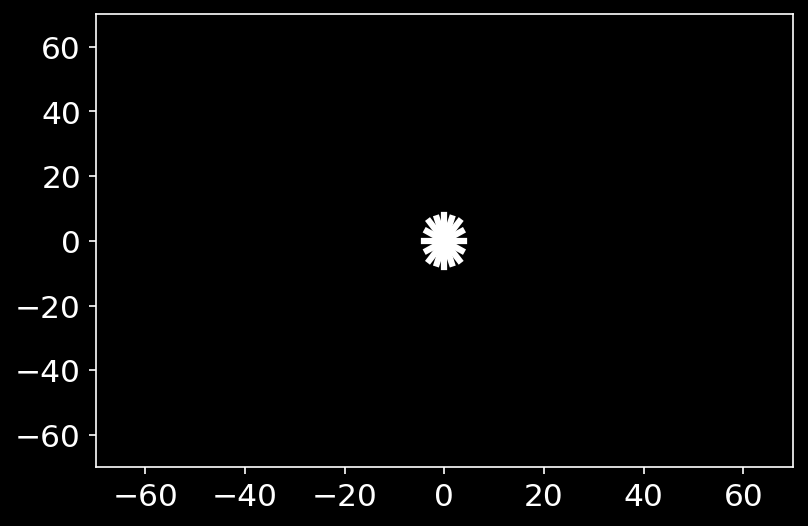

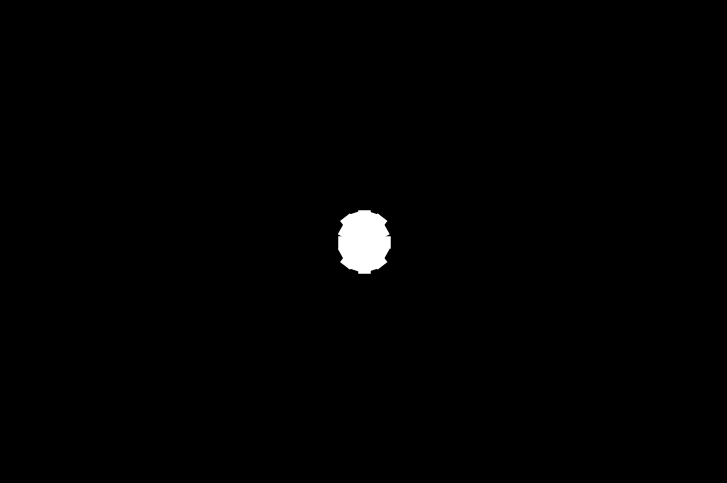

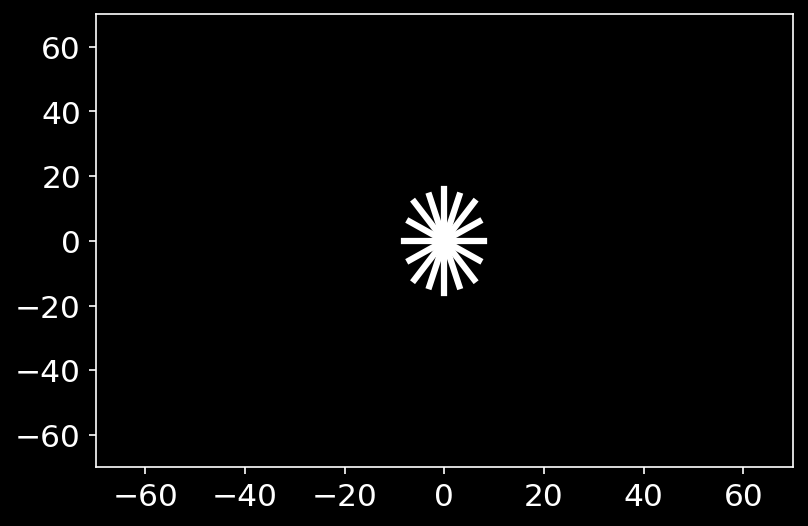

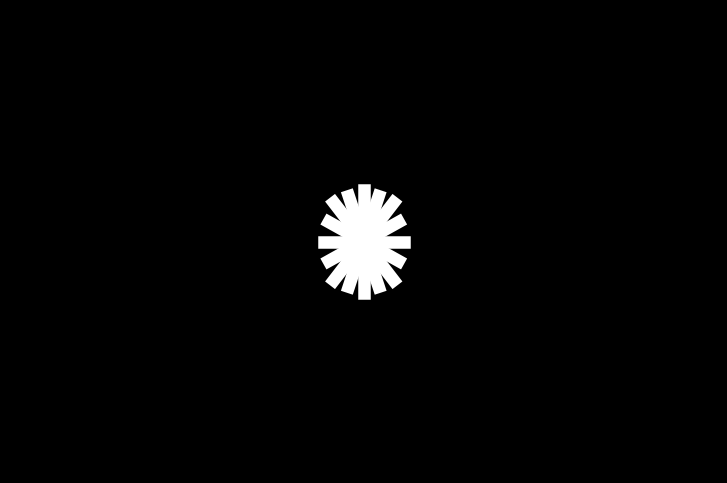

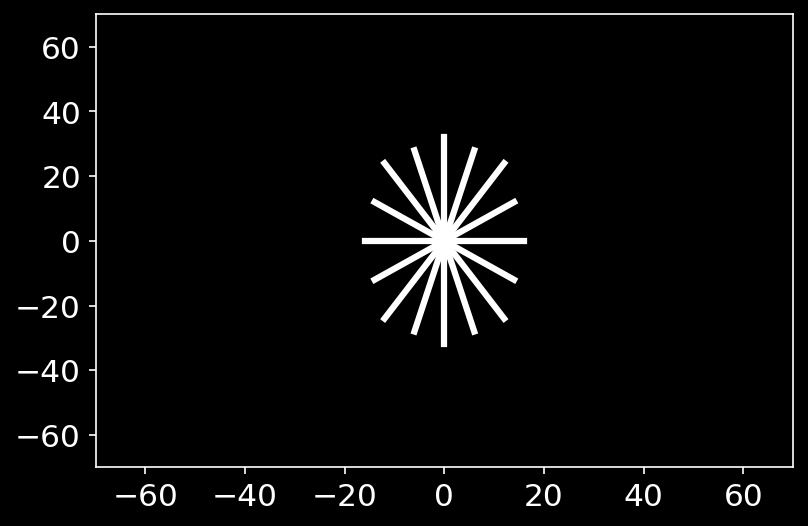

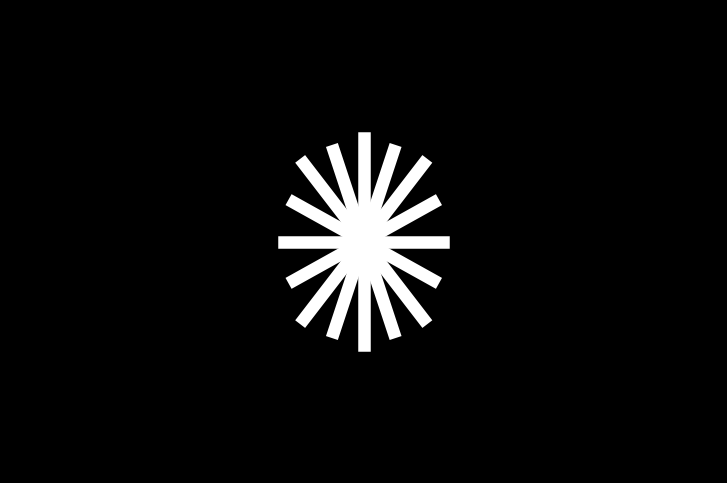

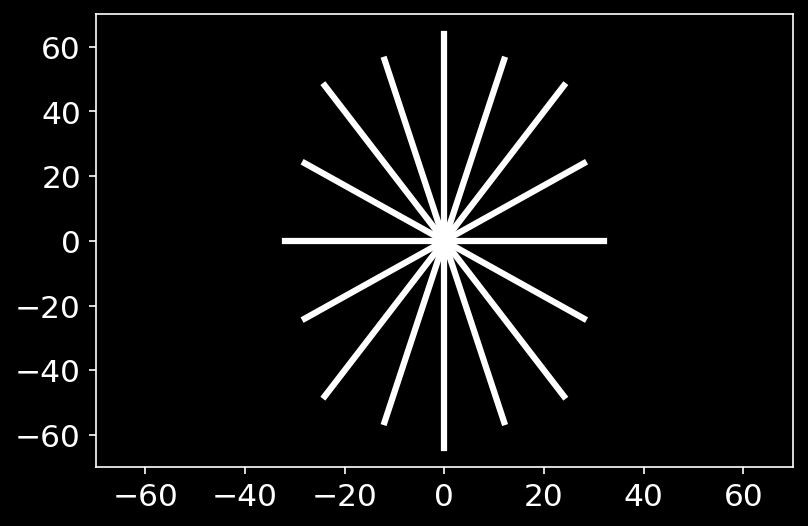

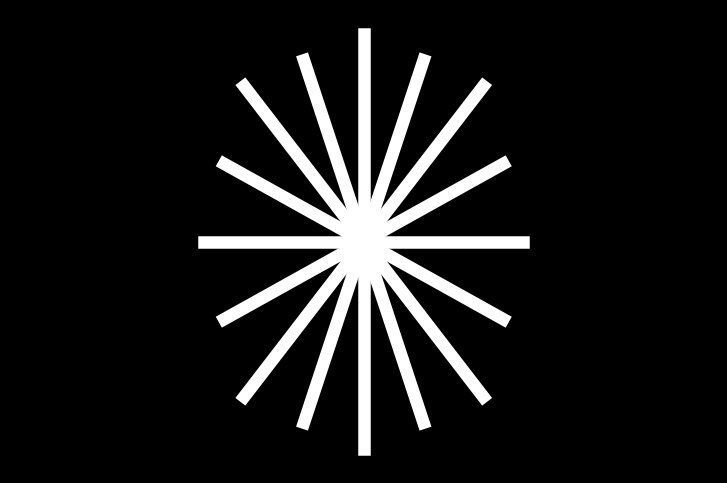

In [67]:
for explosion_number, multiplier in enumerate([1,2,4,8]):
    vector_data = f"""
    EXPL1:
        CSTAT WHITE
        ICVEC
        CM={multiplier}
        CD=1
        CB=07
        SPOK16        ;16 SPOKES 1 SCALE FULL INTENSITY
        .MACRO SPOK16 ;INPUT: CM=SCALE MULTIPLIER
                      ;       CB=INTENSITY
                      ;       CD=SCALE DIVIDER
        ICVEC
        SCVEC 7,3
        SCVEC -7,-3,CB
        SCVEC -6,-6
        SCVEC 6,6,CB
        SCVEC 3,7
        SCVEC -3,-7,CB
        SCVEC 0,-8
        SCVEC 0,8,CB
        SCVEC -3,7
        SCVEC 3,-7,CB
        SCVEC 6,-6
        SCVEC -6,6,CB
        SCVEC -7,3
        SCVEC 7,-3,CB
        SCVEC 8,0
        SCVEC -8,0,CB
        SCVEC 0,0
    """

    vectors = parse_vector_commands(vector_data)
    vertices = vectors_to_coords(vectors)
    plot_vertices(vertices, f"expl_plot_{explosion_number}",)
    plot_vertices_imgonly(vertices,f"expl_img_{explosion_number}",points="",linewidth=6.0)


In [60]:
0xaa7c - 0xaa61, 0xaa91-0xaa7c,0x34f8-0x34c2,0x3522-0x34f8

(27, 21, 54, 42)

In [65]:
0x0e

14